### indepandent compoent analysis


In [2]:
import numpy as np

x = np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])
y = np.array([25,16,9,4,1,0,1,4,9,16,25])

corr_mat = np.corrcoef(x,y)  # Pearson product-moment correlation coefficients
print('corr_mat:\n', corr_mat)
np.correlate(x,y) # Cross-correlation

corr_mat:
 [[1. 0.]
 [0. 1.]]


array([0])

In [13]:
# let's create our signals
np.random.seed(100)

# uniform
U1 = np.random.uniform(-1, 1, 1000)
U2 = np.random.uniform(-1, 1, 1000)

# gaussian
G1 = np.random.randn(1000)
G2 = np.random.randn(1000)

print("u1 shape:", U1.shape)

u1 shape: (1000,)


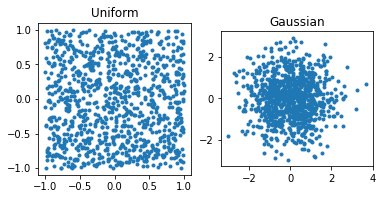

In [11]:
from matplotlib import pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(121, aspect = "equal")
ax1.scatter(U1, U2, marker = ".")
ax1.set_title("Uniform")


ax2 = fig.add_subplot(122, aspect = "equal")
ax2.scatter(G1, G2, marker = ".")
ax2.set_title("Gaussian")


plt.show()

u source shape: (2, 1000)
U_mix shape: (1000, 2)


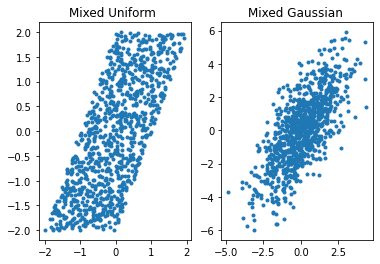

In [15]:
# now comes the mixing part. we can choose a random matrix for the mixing

A = np.array([[1, 0], [1, 2]])

U_source = np.array([U1,U2])
U_mix = U_source.T.dot(A)

G_source = np.array([G1, G2])
G_mix = G_source.T.dot(A)

# plot of our dataset

fig  = plt.figure()

ax1 = fig.add_subplot(121)
ax1.set_title("Mixed Uniform ")
ax1.scatter(U_mix[:, 0], U_mix[:,1], marker = ".")

ax2 = fig.add_subplot(122)
ax2.set_title("Mixed Gaussian ")
ax2.scatter(G_mix[:, 0], G_mix[:, 1], marker = ".")

print("u source shape:", U_source.shape)
print("U_mix shape:", U_mix.shape)
plt.show()

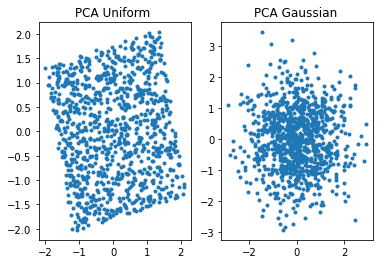

In [16]:
# PCA and whitening the dataset
from sklearn.decomposition import PCA

U_pca = PCA(whiten=True).fit_transform(U_mix)
G_pca = PCA(whiten=True).fit_transform(G_mix)

# let's plot the datasets
fig  = plt.figure()

ax1 = fig.add_subplot(121)
ax1.set_title("PCA Uniform ")
ax1.scatter(U_pca[:, 0], U_pca[:,1], marker = ".")

ax2 = fig.add_subplot(122)
ax2.set_title("PCA Gaussian ")
ax2.scatter(G_pca[:, 0], G_pca[:, 1], marker = ".")

Notice the differences between the uncorrelated(PCA uniform, PCA gaussian2) and source plots(Uniform, Gaussian). In case of Gaussian they look alike while uncorrelated Uniform needs a rotation to get there. By removing correlation in the gaussian case, we have achieved independence between variables. If the source variables are gaussian ICA is not required and PCA is sufficient.  

How do we measure and remove the non-linear dependence between variables?   

Non-linear dependence between the variables can be measured by mutual information among the variables. Higher the mutual information, higher will be the dependence.   
Mutual information = sum of entropies of marginal distribution - entropy of the joint distribution  
Entropy is a measure of uncertainty in a distribution. Entropy for a variable x is given by H(x) = sum(log(P(x))*P(x)) for every possible of value of x.  
The gaussian distribution has the highest entropy. A term closely related to entropy is negentropy which is formulated as
negentropy(x) = H(x_gaussian) - H(x). Here x_gaussian is gaussian random vector with same covariance as x. Thus, negentropy is always non-zero and equal to zero if x is a gaussian random variable. Also,  
mutual information(y1,y2) = constant - sum(negentropy(yi))

Calculation of negentropy and mutual information requires knowledge of entropy. Entropy calculation requires probability distribution function which is not known. We can approximate negentropy with some suitable functions. Few popular examples are tanh(ay), -exp(-y2) and -y*exp(-y2).  

Psuedocode ICA
      G & g are the approximating function and its derivative respectively. X is the dataset.

1. Initialize W
2. X = PCA(X)
3. While W changes:
      W = average(X*G(WX)) - average(g(WTX))W  
      W = orthogonalize(W)  
4. return S = WX

Orthogonalization is a process to make columns of a matrix orthogonal.

How many independent components should be selected? Which independent components should be selected?
ICA outputs a source matrix with columns as independent sources. It never tells us whether a component is significant or irrelevant. If the number of columns is less then checking every component is advisable. For large number of components, selection should be done at the PCA stage(2nd step). If you are unfamiliar with PCA check out the post-1 in this series.

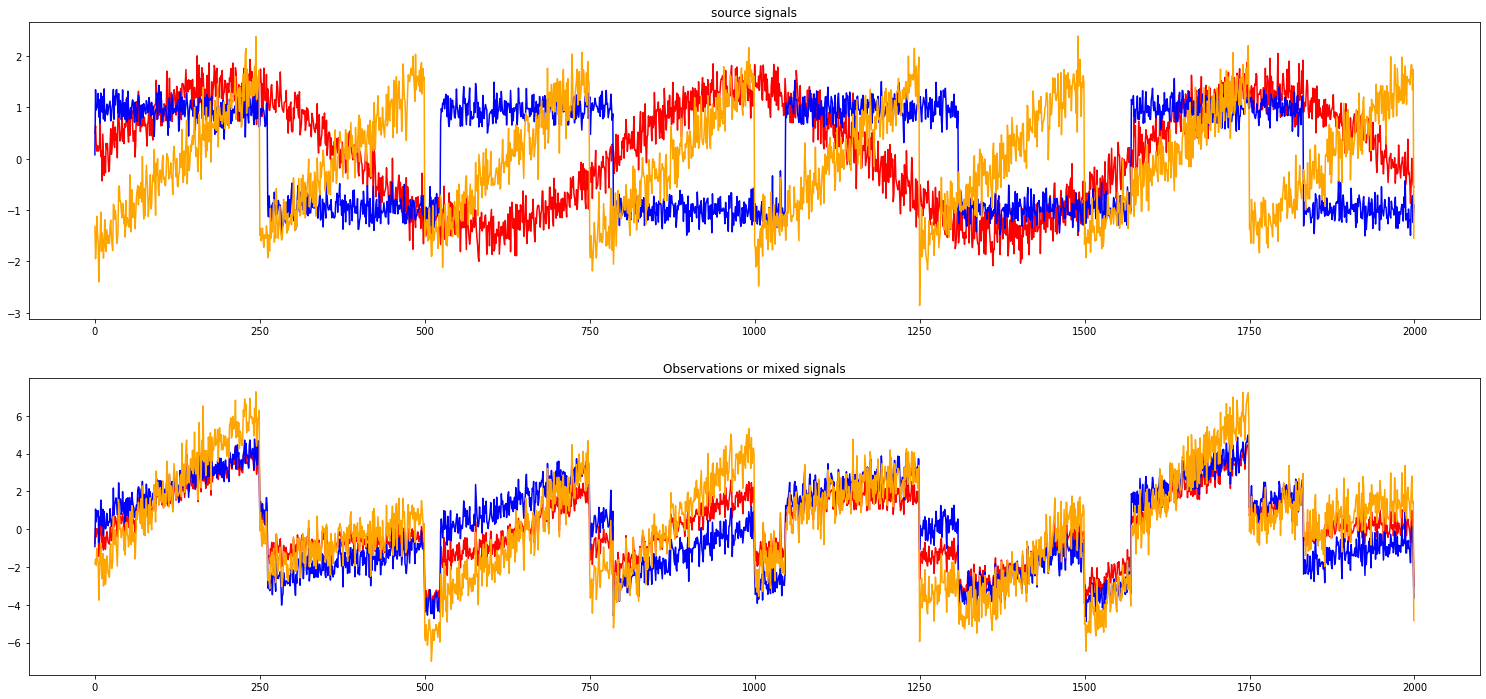

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations


# plot the simulated dataset
plt.figure(figsize =(26,12) )
colors = ['red', 'blue', 'orange']

plt.subplot(2,1,1)
plt.title('source signals')
for color, series in zip(colors, S.T):
    plt.plot(series, color)
plt.subplot(2,1,2)
plt.title('Observations or mixed signals')
for color, series in zip(colors, X.T):
    plt.plot(series, color)

### ICA algorithm - defined from scratch

In [29]:
# approximating function is G(x) = xexp(-x**2/2)
def g(x):
    return x * np.exp(-(x**2)/2)

def gprime(x):
    return (1 - x**2) * np.exp(-(x**2)/2)


# update of Wi
def update_vector(W, X):
    
    Y1 = W.dot(X)
    f1 =  (X * g(Y1)).mean(axis = 1)
    f2 = gprime(Y1).mean() * W
    W = f1 - f2
    return(W)

# orthonormalize the Wi
def orthonormalize(W, w, k):
    
    C= np.zeros_like(w)
    for j in range(k):
        
        C = C + np.dot(w, W[j].T) * W[j]
    w = w - C
    
    return(w /np.sqrt((w * w).sum()))

# calculation of unmixing matrix
# X.shape = number_of_dimensions, number of samples
def calculate_V(X, W_init):
    
    n_f, n_sample = X.shape
    W = np.zeros((n_f, n_f))
    
    for i in range(n_f):
        
        w = W_init[i, :].copy()
        w /= np.sqrt((w**2).sum())
        w_old = np.zeros((1, n_f))
        j=0
        max_iter = 1000
        while (np.abs(np.abs((w*w_old).sum())-1) > 1e-3 and (j < max_iter-1)):
            w_old = w
            w = update_vector(w, X)
            
            w = orthonormalize(W, w, i)
            
            j +=1
        
        W[i, :] = w
        
        
    return(W)

In [30]:
# selection of number of components
# W = unmixing matrix
# S = source signal matrix
def ICA(X, n_comp=None):
    
    X = (X - X.mean(axis = 0))/(X.std(axis=0))
    pca = PCA(whiten=True)
    X_pca = pca.fit_transform(X)
    explained_var = pca.explained_variance_
    if not n_comp:
        n_comp = np.argmax(np.cumsum(explained_var)/explained_var.sum() > 0.99)+1
    K = pca.components_[0:n_comp]/pca.singular_values_
    X_pca = X_pca[:,0:n_comp]
    W_init = np.random.rand(n_comp, n_comp)
    V = calculate_V(X_pca.T, W_init)
    S = V.dot(X_pca.T)
    
    W = V.dot(K)
    
    return(W, S,V,K)

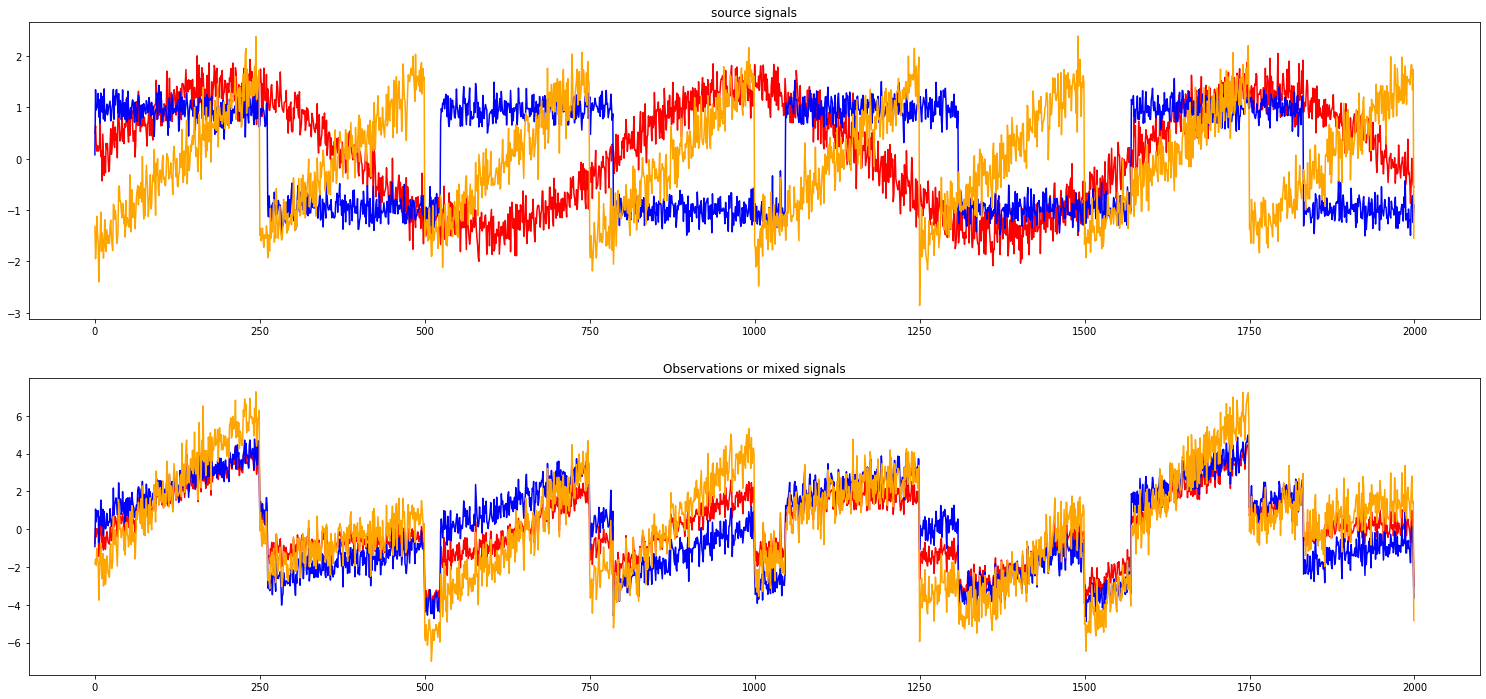

In [31]:
# again define the mixed obsavation signals - also given above
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations


# plot the simulated dataset
plt.figure(figsize =(26,12) )
colors = ['red', 'blue', 'orange']

plt.subplot(2,1,1)
plt.title('source signals')
for color, series in zip(colors, S.T):
    plt.plot(series, color)
plt.subplot(2,1,2)
plt.title('Observations or mixed signals')
for color, series in zip(colors, X.T):
    plt.plot(series, color)

In [32]:
W_, S_,V_ , K_= ICA(X, 3)

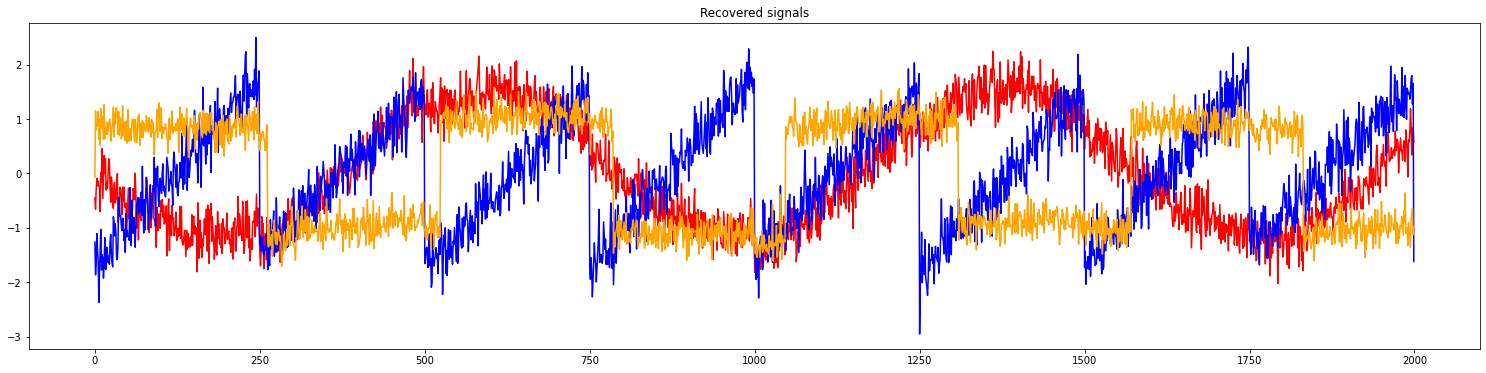

In [33]:
plt.figure(figsize =(26,6) )
plt.title('Recovered signals')
for color, series in zip(colors, S_):
    
    plt.plot(series, color)

## Another Example

### Background on Independent Component Analysis (ICA)

Many M/EEG signals including biological artifacts reflect non-Gaussian processes. Therefore PCA-based artifact rejection will likely perform worse at separating the signal from noise sources. MNE-Python supports identifying artifacts and latent components using temporal ICA. MNE-Python implements the mne.preprocessing.ICA class that facilitates applying ICA to MEG and EEG data. Here we discuss some basics of ICA.

Concepts  
ICA finds directions in the feature space corresponding to projections with high non-Gaussianity.  

* not necessarily orthogonal in the original feature space, but orthogonal in the whitened feature space.  

* In contrast, PCA finds orthogonal directions in the raw feature space that correspond to directions accounting for maximum variance.

* or differently, if data only reflect Gaussian processes ICA and PCA are equivalent.

Example: Imagine 3 instruments playing simultaneously and 3 microphones recording mixed signals. ICA can be used to recover the sources ie. what is played by each instrument.

ICA employs a very simple model: X=AS where X is our observations, A is the mixing matrix and S is the vector of independent (latent) sources.

The challenge is to recover A and S from X.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

np.random.seed(0)  # set seed for reproducible results
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: sawtooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

d:\Drive-2\Softwares\Anaconda\envs\FMLTute\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


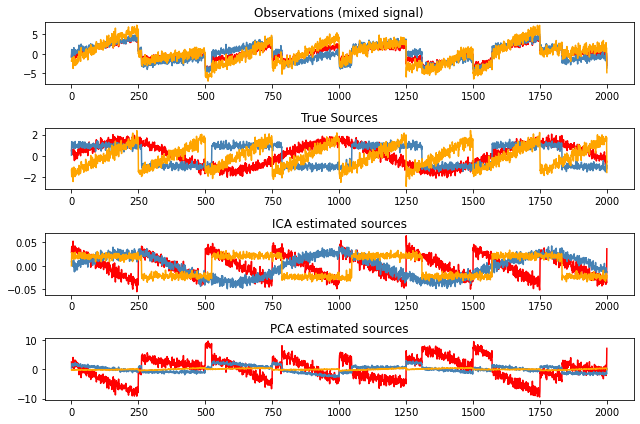

In [26]:
# compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Get the estimated sources
A_ = ica.mixing_  # Get estimated mixing matrix

# compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # estimate PCA sources

plt.figure(figsize=(9, 6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA estimated sources',
         'PCA estimated sources']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()